# Multiple impulses

In this tutorial, we use the {class}`pykep.trajopt.pl2pl_N_impulses` to study a single direct transfer between planets. 

The encoding is original with `pykep` and makes use of a decision vector (chromosome) in the form:
$$
\mathbf x = [t_0,T] + \underbrace{[\alpha_0,u_0,v_0,\Delta V_0, ..... ]}_{\text{propagations}} + \underbrace{[\alpha_{N-1}]}_{\text{Lambert}} + \underbrace{([t_f])}_{\text{Optional phase term}}
$$
to define an $N$ impulse trajectory starting at $t_0$ at the departure planet with a $\Delta V_0$ and arriving at the target planet with a $\Delta V_{N-1}$ and applying the remaining $\Delta V_i$ at epochs encoded using the $\alpha$-encoding for times (see [Multiple Gravity Assist (MGA)](<./udp_mga_1dsm.ipynb>)).

This optimization problem is a nice tool to visualize and study the famous "How many impulses?" question which has a very complicated answer in general.

We start, as often, with some fundamental imports:

In [1]:
import pykep as pk
import numpy as np
import pygmo as pg

We define the problem as an Earth-Venus transfer. We set the transfer time as fixed as well as the departure epoch.

In [69]:
start = pk.planet(pk.udpla.jpl_lp("earth"))
target = pk.planet(pk.udpla.jpl_lp("venus"))

tof_bounds = [360.0, 360.0]
DV_max_bounds = [0.0, 4.0]
phase_free = False
multi_objective = False
t0_bounds = [140, 140.]

udp3 = pk.trajopt.pl2pl_N_impulses(
    start=start,
    target=target,
    N_max=3,
    tof_bounds=tof_bounds,
    phase_free=phase_free,
    multi_objective=multi_objective,
    t0_bounds=t0_bounds,
    DV_max_bounds=DV_max_bounds
)

In [70]:
def solve(udp):
    # We use CMA-ES 
    uda = pg.cmaes(2500, force_bounds=True, sigma0=0.5, ftol=1e-4)
    # But if you prefer a self adaptive version of differential evolution thats also OK.
    #uda = pg.sade(2500, ftol=1e-4, xtol=1e-4)
    algo = pg.algorithm(uda)

    print("Multi-start:")

    res = list()
    for i in range(20):
        pop = pg.population(udp, 20)
        pop = algo.evolve(pop)
        res.append([pop.champion_f, pop.champion_x])
        print(i, pop.champion_f[0], end= '\r')
        

    best_x = sorted(res, key =  lambda x: x[0][0])[0][1]

    print(f"\nThe best solution found has a DV of {udp.fitness(best_x)[0]/1000:.5e} km/s")
    return best_x

best_x_3 = solve(udp3)


Multi-start:
19 6015.332075797623
The best solution found has a DV of 5.98639e+00 km/s


We can easily visualize the solution:

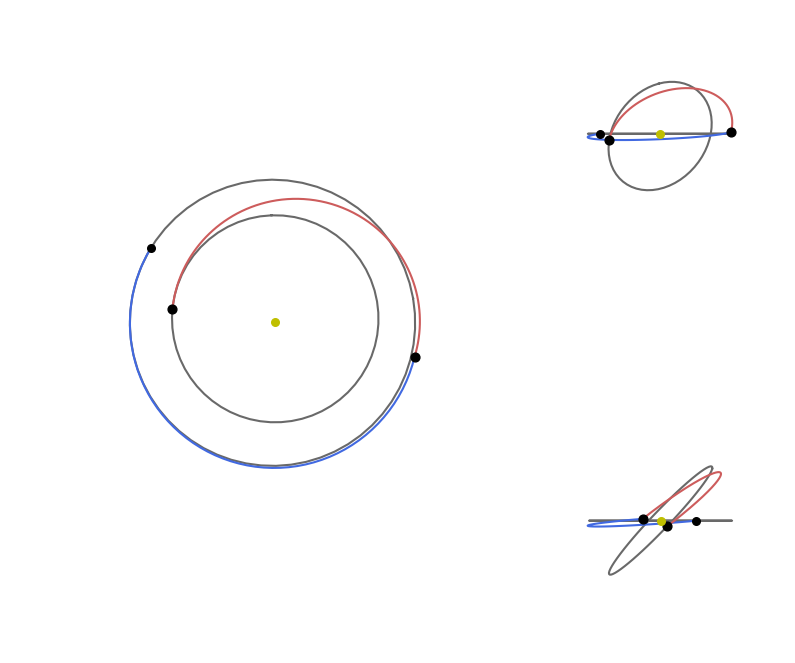

In [71]:
def visualise(udp, best_x):
    import matplotlib.pyplot as plt
    import numpy as np

    # Generate some sample data
    x = np.linspace(0, 10, 100)
    y1 = np.sin(x)
    y2 = np.cos(x)
    y3 = x ** 2

    # Create the figure and define the grid
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], wspace=0.01, hspace=0.01)

    # Top view (spans rows and columns)
    ax1 = fig.add_subplot(gs[:, 0], projection='3d')
    udp.plot(best_x, ax=ax1)
    ax1.view_init(90, 0)
    ax1.axis("off")

    # Ecliptic view 1
    ax1 = fig.add_subplot(gs[0, 1], projection='3d')
    udp.plot(best_x, ax=ax1)
    ax1.view_init(0, 0)
    ax1.axis("off")

    # Ecliptic view 2
    ax1 = fig.add_subplot(gs[1,1], projection='3d')
    udp.plot(best_x, ax=ax1)
    ax1.view_init(0, 90)
    ax1.axis("off")
    return fig

visualise(udp3, best_x_3);


... and quickly investigate a humar readable format for the solution found.

In [73]:
udp3.pretty(best_x_3)

Total DV (m/s):  5986.3894567542975
Dvs (m/s):  [219.50548717541758, 2899.336358455495, 2867.5476111233847]
Total DV (m/s):  360.0
Tofs (days):  [205.942754530339, 154.05724546966098]


# Are more impulses needed?
In the previous design we allowed maximum 3 impulses, but would more impulse be needed? We can quickly answer this question for this specidfic case by repeating the optimization allowing more impulses.

In [74]:
udp4 = pk.trajopt.pl2pl_N_impulses(
    start=start,
    target=target,
    N_max=4,
    tof_bounds=tof_bounds,
    phase_free=phase_free,
    multi_objective=multi_objective,
    t0_bounds=t0_bounds,
    DV_max_bounds=DV_max_bounds
)

In [75]:
best_x_4 = solve(udp4)

Multi-start:
19 5986.4429859569755
The best solution found has a DV of 5.93793e+00 km/s


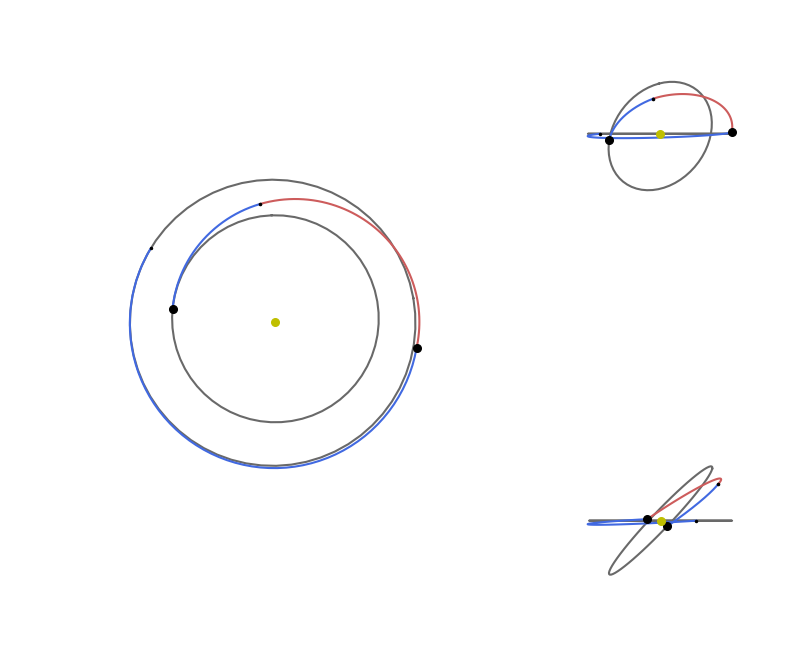

In [76]:
visualise(udp4, best_x_4);

In [77]:
udp4.pretty(best_x_4)

Total DV (m/s):  5937.927401550303
Dvs (m/s):  [197.67866272605482, 2732.2724723889223, 230.95618532970028, 2777.020081105625]
Total DV (m/s):  360.0
Tofs (days):  [209.6658167574209, 102.48578131688357, 47.848401925695526]


We found a better solution! Four impulses are better than 4 in this case! This is quite rare and interesting as a case and its here found as the optimization problem was defined to have a fixed duration and starting date. Typically, when freeing these degrees of freedom, three impulses are enough.

Try to find other interesting cases where the number of impulses matter, and do not be fooled by artefacts. Some times impulses with zero $\Delta V$ are added to move around the starting date outside of the bounds. Whats the maximum number of impulses you can find to be optimal?